With the dataset on international health and population metrics by the US Census Bureau obtained at https://www.kaggle.com/census/international-data, various machine learning algorithms will be applied in order to predict possible future trends in health and population in Canada and other countries of the world. 

This data shows population information such as age, gender, fertility rates, birth rates, death rates, and migration rates among various countries in the world with projections through the year 2050. The dataset is comprised of 8 separate csvs consisting of data related to individual topics with strongly correlated features. The csvs range from about 8 to 100 features due to some having population data for each age group. The total amount of observations in the data is either about 15106 for the csvs containing data that goes by country and year, or 30280 for those that also include data for both female and male sexes along with the country and year. Through analysis of this data, information on human development and life expectancy per country can be extrapolated and trends in population can be used to attempt to predict the future condition of the world.

Through 10-fold cross validation and splitting of data by year, all machine learning implementations done will be supervised tasks. No regularization methods will be performed on the data as well. The main evaluation metrics used will be mean squared error and R-squared score for regression, and precision, recall, accuracy, along with confusion matrices for classification methods.

Using the data in the birth, death, and growth rates dataset first, predictions for growth, migration, birth, and death rates for countries will be made and analyzed.



Using everything but the country and crude death rate as a feature, the crude death rate for Canada will try to be predicted by both gradient boosted trees and linear regression. Since there is no dedicated test set, 10-fold cross validation will be done.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_recall_fscore_support, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('international-data/birth_death_growth_rates.csv').dropna()
can = df[df['country_name'] == 'Canada']

can.head()

,country_code,country_name,year,crude_birth_rate,crude_death_rate,net_migration,rate_natural_increase,growth_rate
4801,CA,Canada,2036,9.28,11.35,5.68,-0.207,0.361
4802,CA,Canada,2022,10.00,9.25,5.70,0.075,0.645
4803,CA,Canada,2023,9.92,9.38,5.70,0.054,0.624
4804,CA,Canada,2024,9.85,9.51,5.69,0.034,0.603
4805,CA,Canada,2025,9.75,9.64,5.69,0.011,0.580


The MSE using cross validation on the entire dataset is 0.06587875653460644


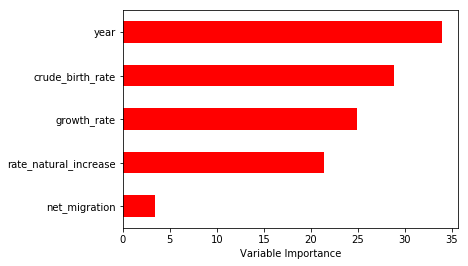

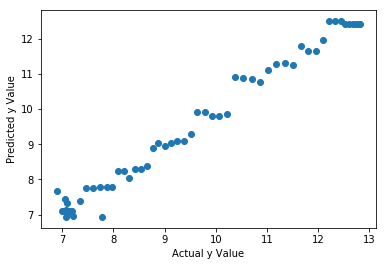

In [14]:
# use everything but country and death rate as features and death rate as the predictor
X = can.drop(['country_code', 'country_name', 'crude_death_rate'], axis=1)
y = can['crude_death_rate']

# cross validation over 10-folds using gradient boosting regressor
kf = KFold(n_splits=10)

preds_cv = []

for train, test in kf.split(X):
    X_cv = X.iloc[train]
    y_cv = y.iloc[train]
    
    X_cv_test = X.iloc[test]
    
    lm_cv = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4, random_state=1)
    lm_cv.fit(X_cv, y_cv)
    preds = lm_cv.predict(X_cv_test)
    preds_cv += list(preds)
    
    # Seeing what is identified as the most important features
    feature_importance = lm_cv.feature_importances_*100
    rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
    rel_imp.T.plot(kind='barh', color='r', )
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None

mse_cv = mean_squared_error(y, preds_cv)
print("The MSE using cross validation on the entire dataset is %s" % mse_cv)

plt.figure()
plt.scatter(y, preds_cv)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()

As seen above, the models seem to do a very good job of predicting Canadian death rates based on the other features. The year also appears to be an important factor in death rates, which makes sense considering death rates tend to get higher as the population increases.

This implementation suggests that if at least the year, birth rate, growth rate, and natural increase rate are known, then future death rates can be predicted with considerable accuracy.

Now, using just the year and birth rate as features with the data up to the year 2017 as training data and the remaining projections as test data, death rates will again be predicted and compared using both gradient boosted trees and linear regression.

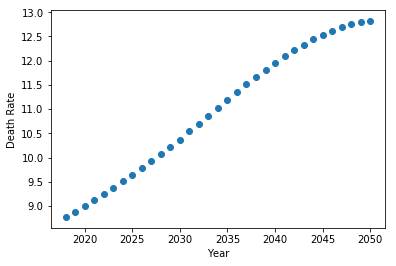

In [54]:
X = can[['year', 'crude_birth_rate']]
y = can[['year', 'crude_death_rate']]

X_train = X[X['year'] <= 2017]
X_test = X[X['year'] > 2017]

y_train = y[y['year'] <= 2017]
y_test = y[y['year'] > 2017]
y_train = y_train['crude_death_rate']
y_test = y_test['crude_death_rate']

# show the projected future death rates in the data
plt.figure()
plt.scatter(X_test['year'], y_test)
plt.xlabel("Year")
plt.ylabel("Death Rate")
plt.show()


7.136897330572812
0.9997638603453899


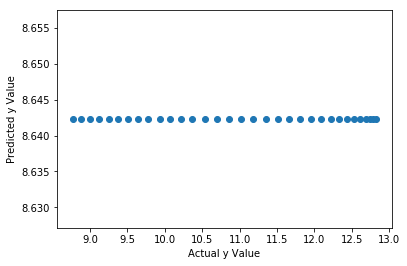

In [60]:
# Gradient Boosted Tree to find future death rates for 2018 and further
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4, random_state=1)
regr.fit(X_train, y_train)

preds = regr.predict(X_test)
print(mean_squared_error(y_test, preds))

preds_rs = regr.predict(X_train)
print(r2_score(y_train, preds_rs))

plt.figure()
plt.scatter(y_test, preds)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()


0.9792908926189323
0.907472373954879


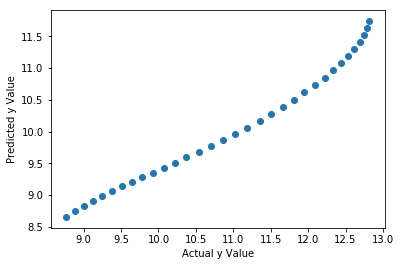

In [58]:
# Linear Regression to find future death rates for 2018 and further
lin = LinearRegression()
lin.fit(X_train, y_train)

preds = lin.predict(X_test)
print(mean_squared_error(y_test, preds))

preds_rs = lin.predict(X_train)
print(r2_score(y_train, preds_rs))

plt.figure()
plt.scatter(y_test, preds)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()


As seen above, when only two features are used linear regression appears to do a much better job at predicting future death rates in comparison to gradient boosted trees. This seems to be due to the lack of features for the tree resulting in death rates always being predicted the same.

This shows that linear regression can be used to predict Canadian death rates with decent accuracy if few features are known. It also shows that future death rates appear to be increasing in a general linear fashion.

Now analysis will be done using the data in the midyear population 5 year age sex dataset. This contains data for the amount of people each country has by sex and year across 5 year intervals.

First using k nearest neighbors, whether a country is Canada or not will be predicted using the other features except total flag and age group indicator. Training data will consist of data in and before 2017 and testing will be after 2017. Then the same will be done using gradient boosted classifier to see which does a better job at identifying if a country is canada or not.

In [105]:
df = pd.read_csv('international-data/midyear_population_5yr_age_sex.csv').dropna()

# change to can if Canada and not if not
for i, row in df.iterrows():
  val = 'not'
  if row['country_name'] == 'Canada':
    val = 'can'
  df.set_value(i,'country_name',val)

df.head()

C:\Users\Brandon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,country_code,country_name,year,total_flag,starting_age,age_group_indicator,ending_age,midyear_population,midyear_population_male,midyear_population_female
0,NO,not,2036,A,0,-,4,324151,166113,158038
1,EG,not,2021,A,100,+,0,327,117,210
2,SN,not,2042,A,90,-,94,102198,40128,62070
3,ZI,not,2005,A,85,-,89,19925,9055,10870
4,SI,not,2035,A,0,-,4,67365,34744,32621


In [111]:
# Use everything but the country, total_flag, and age_group_indicator as features and country_name for predictor
X = df.drop(['country_code', 'country_name', 'total_flag', 'age_group_indicator'], axis=1)
y = df[['year', 'country_name']]


X_train = X[X['year'] <= 2017]
X_test = X[X['year'] > 2017]

y_train = y[y['year'] <= 2017]
y_test = y[y['year'] > 2017]
y_train = y_train['country_name']
y_test = y_test['country_name']

# KNN to predict if a country is canada or not by population information for sex and age
knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_test)

conf = confusion_matrix(y_test, knn_preds)
print('Confusion matrix:\n')
print(knn.classes_)
print(conf)
acc = accuracy_score(y_test, knn_preds)
print('The accuracy is: ', acc)
precision_recall_fscore_support(y_test, knn_preds, pos_label='not', average='binary')


Confusion matrix:

['can' 'not']
[[     7    719]
 [    36 164766]]
The accuracy is:  0.9954388381421875


(0.9956551953349246, 0.999781556049077, 0.9977141092443844, None)

In [112]:
# Gradient Boosting Classifier to predict if a country is canada
gradclass = GradientBoostingClassifier()

gradclass.fit(X_train, y_train)
pred2 = gradclass.predict(X_test)

conf = confusion_matrix(y_test, pred2)
print('Confusion matrix:\n')
print(gradclass.classes_)
print(conf)
tree_acc = accuracy_score(y_test, pred2)
print('Accuracy is: ', tree_acc)
precision_recall_fscore_support(y_test, pred2, pos_label='not', average='binary')


Confusion matrix:

['can' 'not']
[[     1    725]
 [    32 164770]]
Accuracy is:  0.9954267555942197


(0.9956192029970694, 0.9998058275991796, 0.997708123295095, None)

As shown, both do a poor job of identifying Canada, with KNN only predicting Canada correctly 7 times and gradient boosting classifer only prediciting correctly once. Furthermore, there was a large amount of times in both cases where they predicted the country not to be Canada when it actually was. The absurdly high accuracy, precision, and recall is due to the fact that there is a very large amount of the data that doesn't belong to Canada in comparison to that which does, so most will be predicted to not be Canada and be correct. Most likely it's too difficult to distinguish a country based purely on their population statistics by age.

Next, analysis will be done on the midyear population age sex dataset. This contains data for the population for each country by sex and exact age.

Using logisitic regression and random forest classifier, whether a person is male or female will be predicted based on the country and population statisitics. Again, training data will consist of data at and before 2017 with test data being the years following.

In [135]:
df = pd.read_csv('international-data/midyear_population_age_sex.csv').dropna()

In [136]:
df.head()

,country_code,country_name,year,sex,max_age,population_age_0,population_age_1,population_age_2,population_age_3,population_age_4,...,population_age_91,population_age_92,population_age_93,population_age_94,population_age_95,population_age_96,population_age_97,population_age_98,population_age_99,population_age_100
0,AF,Afghanistan,1979,Male,100,318425,299061,282850,268400,255599,...,170,109,67,42,24,14,8,4,2,2
1,AF,Afghanistan,1980,Female,100,303582,253596,255259,249053,239924,...,71,45,27,16,9,6,3,1,1,1
2,AF,Afghanistan,1981,Male,100,278483,253006,228441,233548,226679,...,169,108,67,41,24,14,8,4,2,2
3,AF,Afghanistan,1982,Male,100,260493,226577,217475,198617,205456,...,168,108,67,41,24,14,7,5,2,2
4,AF,Afghanistan,1986,Male,100,288288,244977,225403,207463,204496,...,159,108,67,40,25,13,8,4,2,2


In [141]:
# only take population features for every 20 years
X = df[['year','population_age_1','population_age_20','population_age_40','population_age_60','population_age_80','population_age_100']]
y = df[['year', 'sex']]

X_train = X[X['year'] <= 2017]
X_test = X[X['year'] > 2017]

y_train = y[y['year'] <= 2017]
y_test = y[y['year'] > 2017]
y_train = y_train['sex']
y_test = y_test['sex']

# Logisitic Regression to predict sex by population stats
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)
conf = confusion_matrix(y_test, preds)
print(logreg.classes_)
print(conf)
acc = accuracy_score(y_test, preds)
print('accuracy is: ', acc)
precision_recall_fscore_support(y_test, preds, pos_label='Male', average='binary')


['Female' 'Male']
[[3353 4171]
 [2065 5459]]
accuracy is:  0.5855927698032961


(0.5668743509865005, 0.7255449229133439, 0.6364696280750846, None)

In [146]:
# Random forest to predict sex by population stats

randclass = RandomForestClassifier()

randclass.fit(X_train, y_train)
pred1 = randclass.predict(X_test)

conf = confusion_matrix(y_test, pred1)
print(logreg.classes_)
print(conf)
tree_acc = accuracy_score(y_test, pred1)
print('Accuracy is: ', tree_acc)
precision_recall_fscore_support(y_test, pred1, pos_label='Male', average='binary')


['Female' 'Male']
[[6450 1074]
 [4792 2732]]
Accuracy is:  0.610180754917597


(0.7178139779295849, 0.36310473152578415, 0.48225948808473074, None)

As seen above, random forest only performs slightly better than logistic regression in predicting sex by population. This is likely due to that fact that world populations are fairly equal for both male and female and it's more difficult to discern which is more likely when populations by sex vary so much. It's difficult to predict whether a person is more likely to be female or male based on population statistics if world populations by sex are quite even.

Finally, using the birth death growth rates dataset again, net migration will be predicted using random forests, gradient boosted trees, and linear regression with everything else used as a feature. Rather than taking only Canada's statistics into consideration, birth rates, death rates, natural increase, and growth rate of the world will be used. 10-fold cross validation will be used with both methods to evaluate how well world migration can be predicted through machine learning models.

The MSE using cross validation on the entire dataset is 647.0924977149381


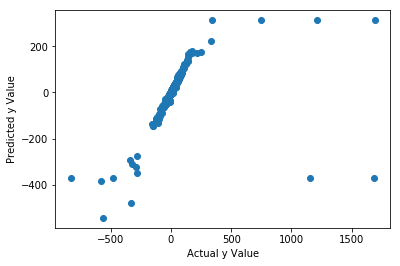

In [157]:
df = pd.read_csv('international-data/birth_death_growth_rates.csv').dropna()

# use everything but country and death rate as features and death rate as the predictor
X = df.drop(['country_code', 'country_name', 'net_migration'], axis=1)
y = df['net_migration']

# cross validation over 10-folds using random forest regressor
kf = KFold(n_splits=10)

preds_cv = []

for train, test in kf.split(X):
    X_cv = X.iloc[train]
    y_cv = y.iloc[train]
    
    X_cv_test = X.iloc[test]
    
    lm_cv = RandomForestRegressor(max_features='auto', random_state=1)
    lm_cv.fit(X_cv, y_cv)
    preds = lm_cv.predict(X_cv_test)
    preds_cv += list(preds)
    

mse_cv = mean_squared_error(y, preds_cv)
print("The MSE using cross validation on the entire dataset is %s" % mse_cv)

plt.figure()
plt.scatter(y, preds_cv)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()

The MSE using cross validation on the entire dataset is 662.919948028643


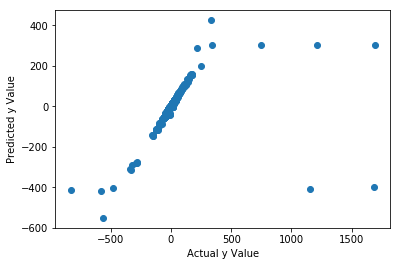

In [158]:
# cross validation over 10-folds using gradient boosted trees
kf = KFold(n_splits=10)

preds_cv = []

for train, test in kf.split(X):
    X_cv = X.iloc[train]
    y_cv = y.iloc[train]
    
    X_cv_test = X.iloc[test]
    
    lm_cv = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4, random_state=1)
    lm_cv.fit(X_cv, y_cv)
    preds = lm_cv.predict(X_cv_test)
    preds_cv += list(preds)
    

mse_cv = mean_squared_error(y, preds_cv)
print("The MSE using cross validation on the entire dataset is %s" % mse_cv)

plt.figure()
plt.scatter(y, preds_cv)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()

The MSE using cross validation on the entire dataset is 1174.4424052051854


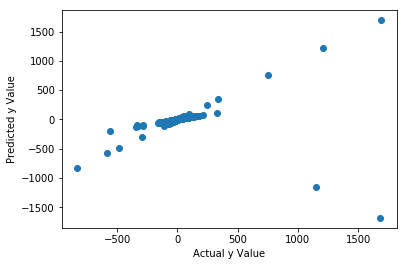

In [161]:
# cross validation over 10-folds using linear regression
kf = KFold(n_splits=10)

preds_cv = []

for train, test in kf.split(X):
    X_cv = X.iloc[train]
    y_cv = y.iloc[train]
    
    X_cv_test = X.iloc[test]
    
    lm_cv = LinearRegression()
    lm_cv.fit(X_cv, y_cv)
    preds = lm_cv.predict(X_cv_test)
    preds_cv += list(preds)
    

mse_cv = mean_squared_error(y, preds_cv)
print("The MSE using cross validation on the entire dataset is %s" % mse_cv)

plt.figure()
plt.scatter(y, preds_cv)
plt.xlabel("Actual y Value")
plt.ylabel("Predicted y Value")
plt.show()

This shows that while random forests performs the best, they all do a fair job at predicting world migration rates when they're close to 0. However, they also have trouble predicting large negative or positive values due to their trouble in handling outliers. At points in time where country migration rates aren't affected by unforeseen circumstances and remain steady, machine learning models may do a decent job at prediction.

An interesting finding after performing these machine learning tasks over this data is that while certain rates such as death rate can be predicted rather easily, other rates such as migration rates are more difficult to anticipate. This is because something like death will always go up at a steady rate due to the rapidly increasing world population, but country migration may happen suddenly for many different political or societal reasons and is therefore much more unpredictable.

A final interesting finding is the fact that population by sex isn't enough on it's own to predict individual sex. Because of the common conception that women live longer than men, I figured that the data would scew more towards there being more people of the female sex worldwide and therefore train the model to predict more heavily towards the female side. However, this didn't seem to be the case since the models predicted women and men almost equally.